# SVR

### Data Preprocessing

In [7]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Read training and testing data, using the first column as the row index and the first row as the column names
train_data = pd.read_excel('US_PCE_training.xlsx', index_col=0)
test_data = pd.read_excel('US_PCE_testing_fake.xlsx', index_col=0)

# Extract PCE data
train_pce = train_data.iloc[0, :] 
test_pce = test_data.iloc[0, :] 

# Combine PCE data and calculate the inflation rate
combined_pce = pd.concat([train_pce, test_pce]).astype(float)
combined_inflation_rate = np.log(combined_pce).diff() * 12  
combined_inflation_rate = combined_inflation_rate.dropna()

# Split the training and testing inflation rates
train_inflation_rate = combined_inflation_rate.iloc[:len(train_pce)-1]
test_inflation_rate = combined_inflation_rate.iloc[len(train_pce)-1:]

# Extract feature variables
train_features = train_data.iloc[4:].T 
test_features = test_data.iloc[3:].T

combined_features = pd.concat([train_features, test_features]).astype(float)
combined_predictors = np.log(combined_features).diff() * 12
combined_predictors = combined_predictors.dropna()

train_predictors = combined_predictors.iloc[:len(train_features)-1,:] 
test_predictors = combined_predictors.iloc[len(train_features)-1:,]

# Normalize features
scaler = StandardScaler()
train_predictors_scaled = scaler.fit_transform(train_predictors)
test_predictors_scaled = scaler.transform(test_predictors)
train_predictors_scaled = pd.DataFrame(train_predictors_scaled,index=train_predictors.index,columns=train_predictors.columns)
test_predictors_scaled = pd.DataFrame(test_predictors_scaled,index=test_predictors.index,columns=test_predictors.columns)

### Model Training and In-Sample Fitting

In [12]:
train_predictors_scaled = np.array(train_predictors_scaled)
test_predictors_scaled = np.array(test_predictors_scaled)
def prepare_data(features, target, n_lags, horizon):
    X, y = [], []
    # Loop over the indices of the target array that allow for both lags and horizon
    for i in range(n_lags + horizon, len(target)):
        start_idx = i - horizon - n_lags
        end_idx = i - horizon
       
        feature_set = features[start_idx:end_idx].flatten()  # Lagged predictor features
        target_lags = target[start_idx:end_idx].flatten()  # Lagged values of the target variable
        X.append(np.hstack([feature_set, target_lags]))
        y.append(target[i])
    return np.array(X), np.array(y)

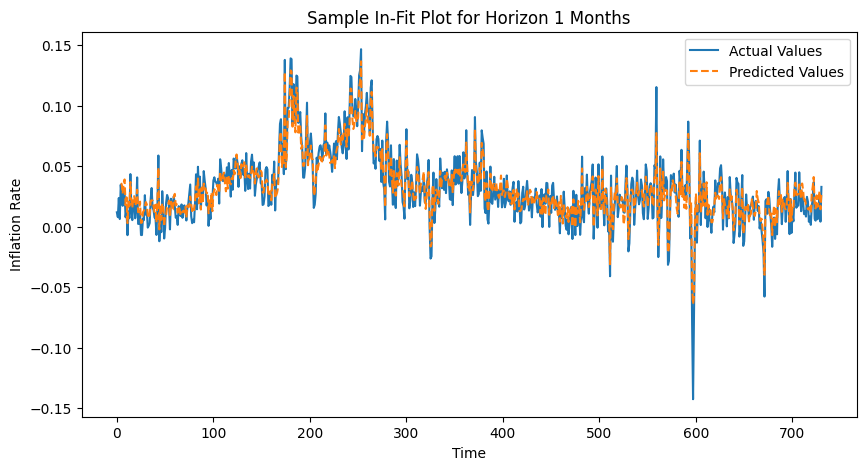

Horizon 1 months: Best Parameters: {'C': 0.1, 'epsilon': 0.01, 'gamma': 'auto'}
Horizon 1 months: MSE = 0.000084


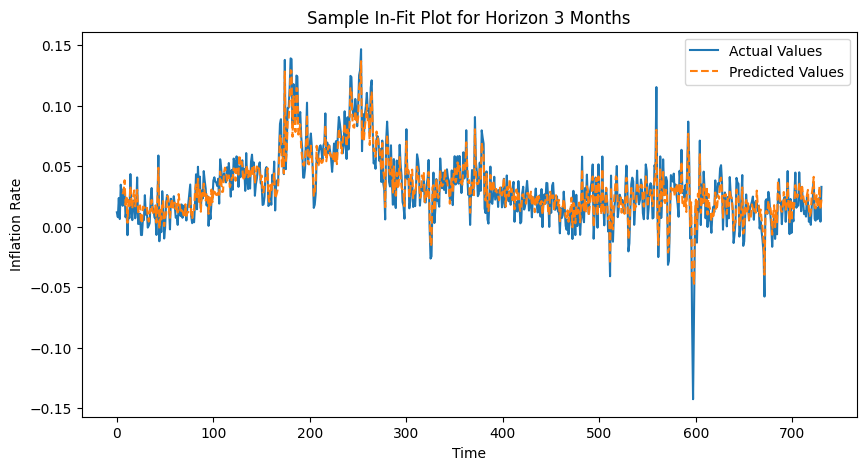

Horizon 3 months: Best Parameters: {'C': 0.1, 'epsilon': 0.01, 'gamma': 'auto'}
Horizon 3 months: MSE = 0.000093


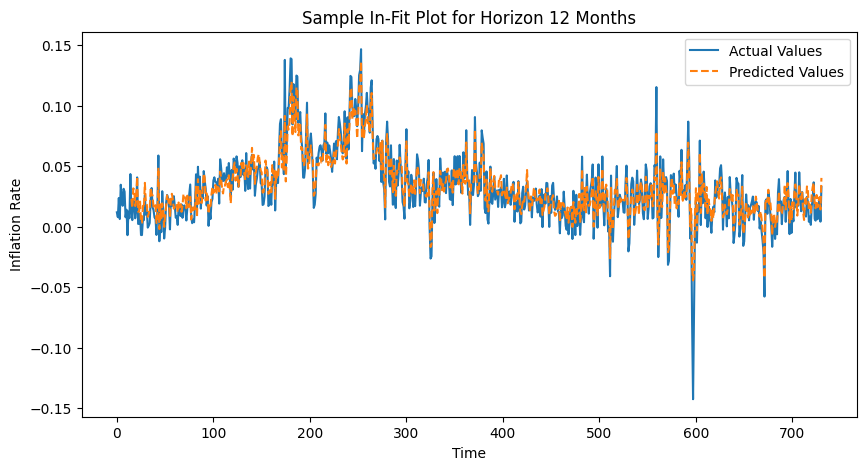

Horizon 12 months: Best Parameters: {'C': 0.1, 'epsilon': 0.01, 'gamma': 'auto'}
Horizon 12 months: MSE = 0.000100


In [14]:
# Model training and evaluation for different horizons
horizons = [1, 3, 12]
n_lags = 3
models = {}
mse_scores = {}

for horizon in horizons:
    X_train, y_train = prepare_data(train_predictors_scaled, train_inflation_rate.values, n_lags, horizon)
    param_grid = {
        'C': [0.1, 1, 10],
        'epsilon': [0.01, 0.1, 0.5],
        'gamma': ['auto', 'scale', 0.01, 0.1]
    }
    tscv = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    models[horizon] = best_model
    y_pred = best_model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    mse_scores[horizon] = mse

    # Plotting actual vs predicted values
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(train_inflation_rate)), train_inflation_rate, label='Actual Values')
    pred_start = n_lags + horizon
    plt.plot(range(pred_start, pred_start + len(y_pred)), y_pred, label='Predicted Values', linestyle='--')
    plt.title(f'Sample In-Fit Plot for Horizon {horizon} Months')
    plt.xlabel('Time')
    plt.ylabel('Inflation Rate')
    plt.legend()
    plt.show()

    print(f"Horizon {horizon} months: Best Parameters: {grid_search.best_params_}")
    print(f"Horizon {horizon} months: MSE = {mse:.6f}")

### Pseudo Out-of-Sample Prediction

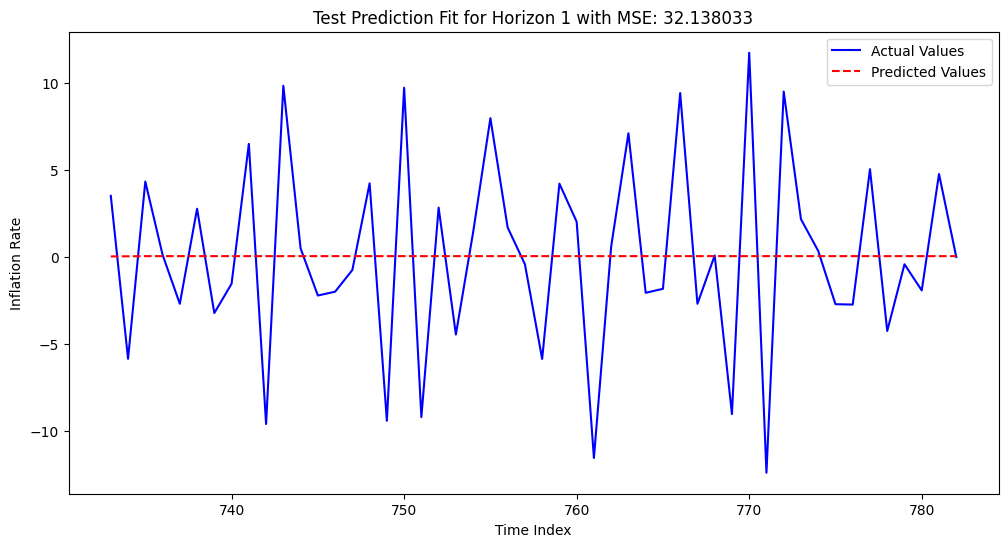

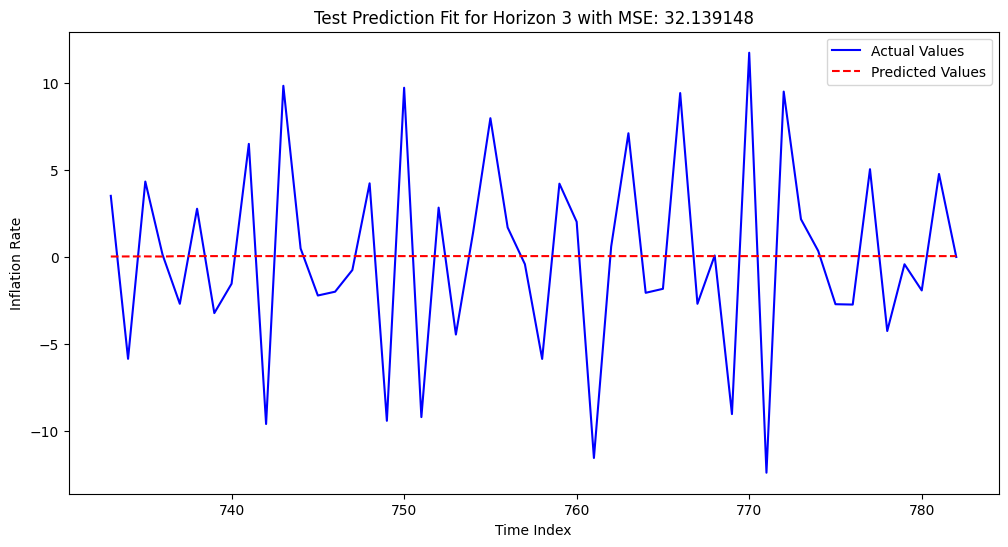

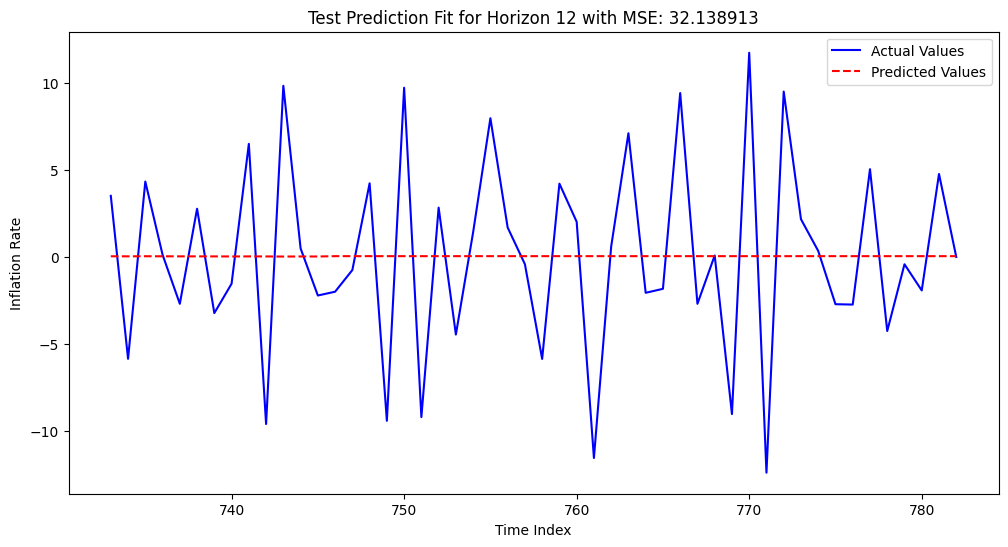

In [18]:
def prepare_test_data(train_features, train_target, test_features, test_target, n_lags, horizon):
    # Extend test features by including sufficient training set tail data to handle lag and horizon
    combined_features = np.vstack([train_features[-(n_lags + horizon):], test_features])
    combined_target = np.concatenate([train_target[-(n_lags + horizon):], test_target])
    
    X_test, y_test = [], []
    # Start index is after the initial n_lags + horizon to form a complete first set of features
    start_index = n_lags + horizon

    # Iterate through combined data to form feature and target sets for testing
    for i in range(start_index, len(combined_target)):
        start_idx = i - n_lags - horizon
        end_idx = i - horizon
        # Flatten feature sets to create a single array per sample
        feature_set = combined_features[start_idx:end_idx].flatten()
        target_lags = combined_target[start_idx:end_idx].flatten()
        
        X_test.append(np.hstack([feature_set, target_lags]))
        y_test.append(combined_target[i])

    return np.array(X_test), np.array(y_test)

test_mses = {}
for horizon in horizons:
    X_test, y_test = prepare_test_data(train_predictors_scaled, train_inflation_rate, test_predictors_scaled, test_inflation_rate, n_lags, horizon)
    model = models[horizon]  # Retrieve the model trained for this specific horizon
    
    y_pred_test = model.predict(X_test)
    test_mses[horizon] = mean_squared_error(y_test, y_pred_test)

    end_idx = len(combined_inflation_rate)  
    start_idx = end_idx - 50  

    plt.figure(figsize=(12, 6))
    plt.plot(combined_inflation_rate.index[start_idx:end_idx], y_test, label='Actual Values', color='blue')
    plt.plot(combined_inflation_rate.index[start_idx:end_idx], y_pred_test, label='Predicted Values', linestyle='--', color='red')
    plt.title(f"Test Prediction Fit for Horizon {horizon} with MSE: {test_mses[horizon]:.6f}")
    plt.xlabel('Time Index')
    plt.ylabel('Inflation Rate')
    plt.legend()
    plt.show()